# $NicheVI-workflow$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from scvi.strip_metrics import SpatialAnalysis

In [3]:
scvi.settings.seed = 34

Global seed set to 34


In [4]:
# !ls /home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH

!ls /home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/

adata_MERFISH_24w.h5ad
adata_scvi_merfish4w.h5ad
BrainAging_MERFISH_4weeks_major_ct.h5ad
BrainAgingSpatialAtlas_MERFISH_24weeks.h5ad
BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad
BrainAgingSpatialAtlas_MERFISH.h5ad
BrainAgingSpatialAtlas_MERFISH.ipynb


In [5]:
plots = True

In [6]:
data_dirs = {
    "VIZGEN_Liver": [
        "/home/nathanlevy/Data/Liver_VIZGEN/",
        "liver-joint-scvi3-annotated.h5ad",
    ],
    "MERFISH_Brain": [
        # "/home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH/",
        "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/",
        # "adata_scvi_merfish4w.h5ad",
        # "BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad",
        "BrainAging_MERFISH_4weeks_major_ct.h5ad",
    ],
    "NANOSTRING_Lung": [
        "/home/nathanlevy/Data/",
        "nanostring_bis_finished_hotspot_densities.h5ad",
    ],
}

In [7]:
# data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
# data_file = "adata_scvi_merfish4w.h5ad"

data_dir, data_file = data_dirs["MERFISH_Brain"]

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

BrainAging_MERFISH_4weeks_major_ct

In [8]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [9]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123005 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'centroids', 'spatial'
    layers: 'counts'

In [10]:
adata.obs["cell_type"].value_counts()

cell_type
neuron                            34554
medium spiny neuron               25668
oligodendrocyte                   13113
astrocyte                         12831
endothelial cell                  11376
inhibitory interneuron            10330
microglial cell                    6317
oligodendrocyte precursor cell     4235
pericyte                           3443
vascular leptomeningeal cell       1138
Name: count, dtype: int64

In [11]:
# adata.X = adata.layers["counts"]  # putting in the X matrtix the raw counts
# adata.obs["cell_type"] = adata.obs['annotation']

# # subset the data to only include the samples we want to analyze: Liver1Slice1 and Liver2Slice1
# adata = adata[
#     adata.obs["sample"].isin(["Liver1Slice1", "Liver2Slice1"])
# ].copy()

# subset the anndata to remove macrophage, cell and T cell:
# adata = adata[~adata.obs["cell_type"].isin(["macrophage", "T cell", "cell"])].copy()

adata.obsm["centroids"] = adata.obs[["center_x", "center_y"]].values

In [12]:
# save the adata
# adata.write_h5ad(data_dir + "/BrainAging_MERFISH_4weeks_major_ct.h5ad")

In [13]:
print(adata)

AnnData object with n_obs × n_vars = 123005 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'centroids', 'spatial'
    layers: 'counts'

In [14]:
# for sample in adata.obs.donor_slice.unique().tolist()[:1]:
#     sc.pl.spatial(
#         adata[adata.obs.donor_slice == sample],
#         spot_size=40,
#         color=["cell_type", "donor_id"],
#         ncols=2,
#         frameon=False,
#         title=sample,
#     )

## First train (linear)scVI

In [15]:
N_LAYERS = 1
N_LATENT = 10
LIKELIHOOD = "poisson"
BATCH_KEY = "donor_id"
######################
N_EPOCHS_LVAE = 130
N_EPOCHS_SCVI = 200
N_EPOCHS_NICHEVI = 202
######################
WEIGHT_DECAY = 1e-3
KL_WARMUP = None
REC_WARMUP = None
MIN_REC_WEIGHT = 1.0
MAX_REC_WEIGHT = 1.0

In [16]:
lvae_is_trained = True
save_lvae = True

if lvae_is_trained:
    vae = scvi.model.LinearSCVI.load(
        dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS_LVAE) + ".pt", adata=adata
    )

if lvae_is_trained == False:
    scvi.model.LinearSCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    vae = scvi.model.LinearSCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    vae.train(
        max_epochs=N_EPOCHS_LVAE,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=KL_WARMUP, weight_decay=WEIGHT_DECAY),
        early_stopping=True,
    )

    if save_lvae:
        vae.save(
            dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS_LVAE) + ".pt",
            save_anndata=False,
        )

INFO     File checkpoints/BrainAging_MERFISH_4weeks_major_ct/lvae_E130.pt/model.pt already downloaded              


In [17]:
vae.summary_stats  #

n_batch: 4
n_cells: 123005
n_labels: 1
n_vars: 374

In [18]:
# if plots:
#     sc.pp.neighbors(adata, use_rep="qz1_m")
#     sc.tl.umap(adata, min_dist=0.3)

#     if "niche_type" in adata.obs.columns:
#         sc.pl.umap(
#             adata,
#             color=["cell_type", "niche_type"],
#             ncols=3,
#             frameon=False,
#             palette="tab20",
#         )

#     else:
#         sc.pl.umap(
#             adata,
#             color=["cell_type", "donor_id"],
#             ncols=2,
#             frameon=False,
#             palette="tab20",
#         )

In [19]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

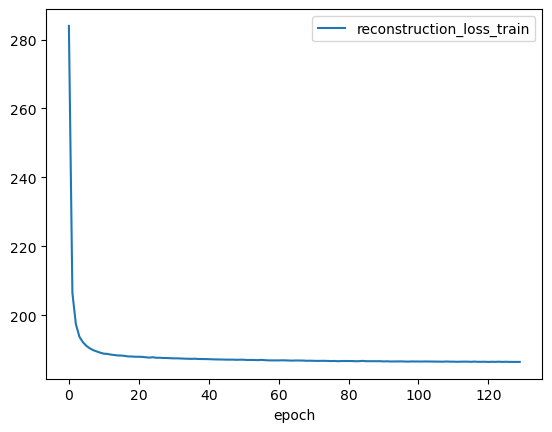

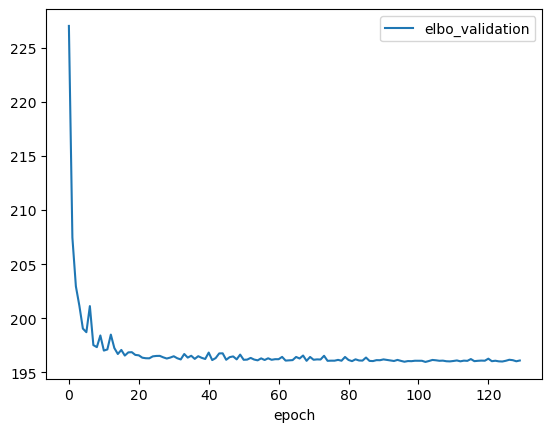

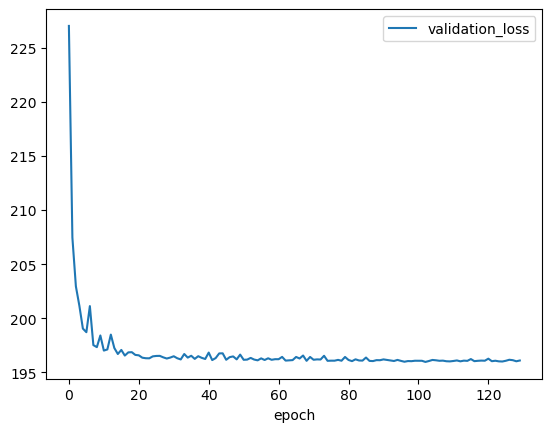

In [20]:
vae.history["reconstruction_loss_train"].plot()
vae.history["elbo_validation"].plot()
vae.history["validation_loss"].plot()

In [21]:
is_trained = True
save_scvi = False

if is_trained == False:
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    scvivae = scvi.model.SCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    scvivae.train(
        max_epochs=N_EPOCHS_SCVI,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=KL_WARMUP, weight_decay=WEIGHT_DECAY),
        # trainer_kwargs=dict(check_val_every_n_epoch=1),
        early_stopping=True,
    )

    if save_scvi:
        scvivae.save(
            dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS_SCVI) + ".pt",
            save_anndata=False,
        )

if is_trained:
    scvivae = scvi.model.SCVI.load(
        dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS_SCVI) + ".pt", adata=adata
    )

adata.obsm["X_scVI"] = scvivae.get_latent_representation()

INFO     File checkpoints/BrainAging_MERFISH_4weeks_major_ct/scvivae_E200.pt/model.pt already downloaded           


In [22]:
adata.obsm["qz1_m"], adata.obsm["qz1_var"] = scvivae.get_latent_representation(
    return_dist=True
)

In [23]:
scvivae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

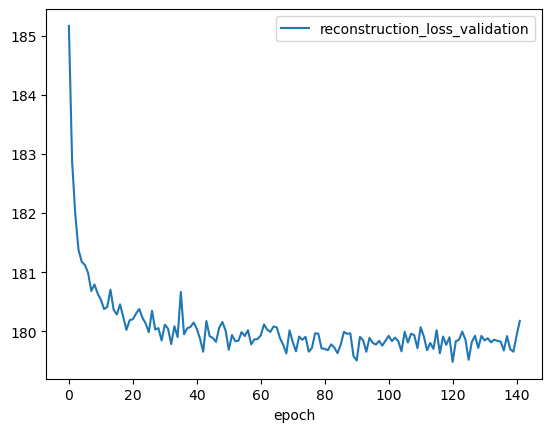

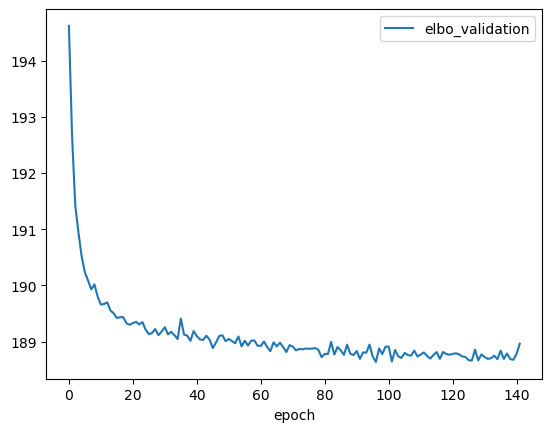

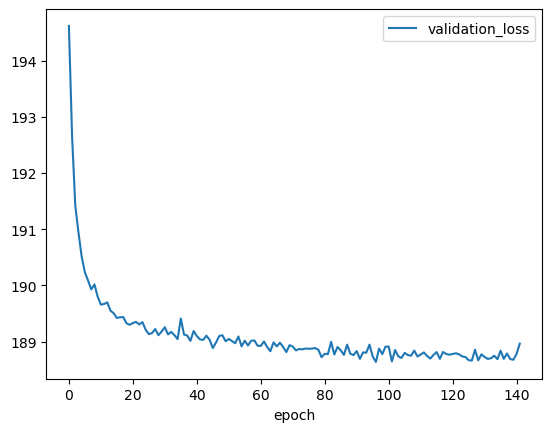

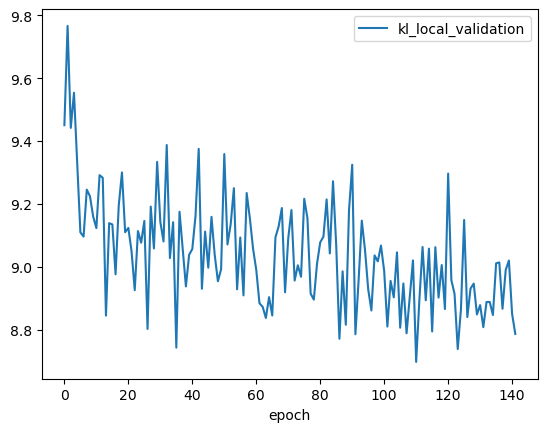

In [24]:
scvivae.history["reconstruction_loss_validation"].plot()
scvivae.history["elbo_validation"].plot()
scvivae.history["validation_loss"].plot()
scvivae.history["kl_local_validation"].plot()

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23

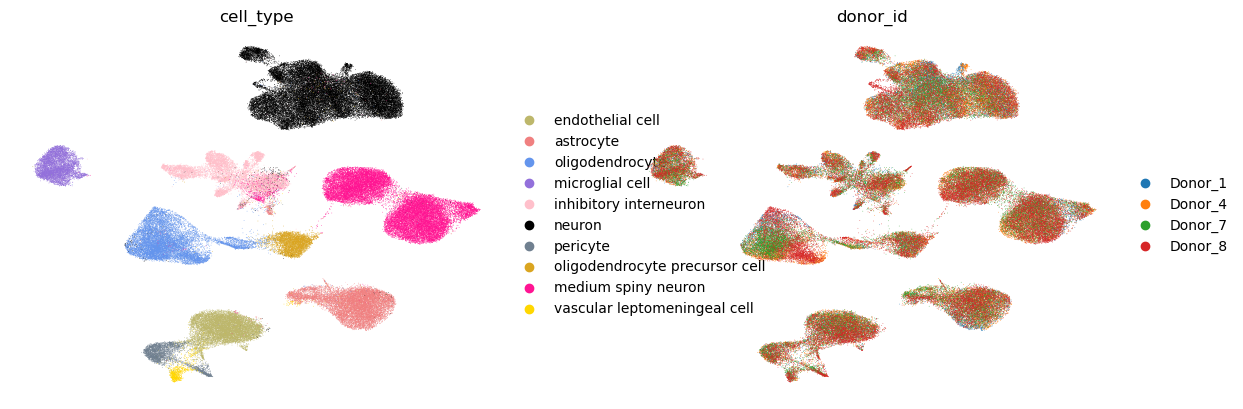

In [25]:
if plots:
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.3)

    if "niche_type" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["cell_type", "niche_type"],
            ncols=3,
            frameon=False,
        )

    else:
        sc.pl.umap(
            adata,
            color=["cell_type", "donor_id"],
            ncols=2,
            frameon=False,
        )

In [26]:
# sc.pl.umap(
#     adata,
#     color=["niche_cell_type"],
#     frameon=False,
# )

## Then train $nicheVI$

Parameters

In [27]:
K_NN = 20
N_LAYERS_NICHE = 1
N_LAYERS_COMPO = 1
N_HIDDEN = 128
N_HIDDEN_COMPO = 96
N_HIDDEN_NICHE = 128
SAMPLE_KEY = "donor_slice"
SOFTMAX_TEMPERATURE = 1.0

In [28]:
# preprocessing function to populate adata.obsm with the keys 'neighborhood_composition',
# 'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct',
# 'qz1_var_niche_ct'

scvi.model.nicheSCVI.preprocessing_anndata(
    adata,
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    niche_type_key="niche_type",
    niche_treshold=0.2,
    cell_type_for_niches=[
        "neuron",
        "oligodendrocyte",
        "astrocyte",
        "medium spiny neuron",
    ],
    label_key="cell_type",
    sample_key=SAMPLE_KEY,
    cell_coordinates_key="centroids",
    k_nn=K_NN,
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    # latent_mean_niche_keys=None,
    latent_mean_niche_keys=["qz1_m_niche_ct"],
    latent_var_niche_keys=["qz1_var_niche_ct"],
    latent_mean_knn_key="latent_mean_knn",
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

/home/nathanlevy/spatial-scvi/scvi/model/_nichescvi.py:599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)


In [ ]:
# # for sample in adata.obs.donor_slice.unique().tolist()[:1]:
# for sample in ["Donor_8-slice_2"]:
#     adata_sample = adata[adata.obs["donor_slice"] == sample].copy()

#     for dim in range(10):
#         # adata_sample.obs["z1_neuron"] = adata_sample.obsm["qz1_m_niche_ct"][:, 3, dim]
#         adata_sample.obs["z1_neuron"] = adata_sample.obsm["X_scVI_mean"][:, dim]
#         sc.pl.spatial(
#             adata=adata_sample,
#             spot_size=40,
#             color=["z1_neuron"],
#             ncols=2,
#             frameon=False,
#             title=sample + " dim " + str(dim),
#             palette="magma",
#         )

In [ ]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_spatial, X_umap, centroids, spatial, X_scVI, qz1_m, qz1_var, niche_indexes, niche_distances, neighborhood_composition, latent_mean_knn, qz1_m_niche_ct, qz1_var_niche_ct)

In [ ]:
adata.obs["niche_cell_type"] = (
    adata.obs["niche_type"].astype(str) + "_" + adata.obs["cell_type"].astype(str)
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


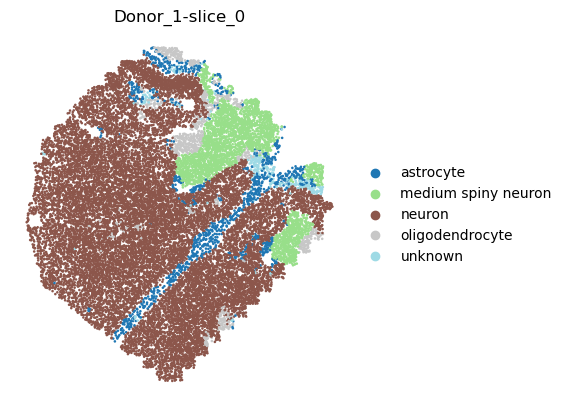

In [ ]:
for sample in adata.obs.donor_slice.unique().tolist()[:1]:
    sc.pl.spatial(
        adata=adata[adata.obs["donor_slice"] == sample],
        spot_size=40,
        color=["niche_type"],
        ncols=1,
        frameon=False,
        title=sample,
        palette="tab20",
    )

In [ ]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_spatial, X_umap, centroids, spatial, X_scVI, qz1_m, qz1_var, niche_indexes,
niche_distances, neighborhood_composition, latent_mean_knn, qz1_m_niche_ct, qz1_var_niche_ct)

In [ ]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key=BATCH_KEY,
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niche_ct",
    latent_var_ct_key="qz1_var_niche_ct",
)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [ ]:
niche_setup = {
    "r1_kl1_c0_n0": {
        "cell_rec_weight": 1,
        "niche_rec_weight": 0.0,
        "niche_compo_weight": 0.0,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
    },
    "r0_kl0_c1_n0": {
        "cell_rec_weight": 0.0,
        "niche_rec_weight": 0.0,
        "niche_compo_weight": 1.0,
        "latent_kl_weight": 0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
    },
    "r0_kl0_c0_n1": {
        "cell_rec_weight": 0.0,
        "niche_rec_weight": 1,
        "niche_compo_weight": 0.0,
        "latent_kl_weight": 0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
    },
    "r0_kl01_c10_n0": {
        "cell_rec_weight": 0.0,
        "niche_rec_weight": 0.0,
        "niche_compo_weight": 10,
        "latent_kl_weight": 0.1,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
    },
    "r01_kl1_c0_n10": {
        "cell_rec_weight": 0.1,
        "niche_rec_weight": 10,
        "niche_compo_weight": 0,
        "latent_kl_weight": 1,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN,
        "n_hidden_compo": N_HIDDEN,
    },
    "r01_kl1_c10_n0": {
        "cell_rec_weight": 0.1,
        "niche_rec_weight": 0,
        "niche_compo_weight": 10,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN,
        "n_hidden_compo": N_HIDDEN,
    },
    "r1_kl1_c1_n1": {
        "cell_rec_weight": 1,
        "niche_rec_weight": 1,
        "niche_compo_weight": 1,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN,
        "n_hidden_compo": N_HIDDEN,
    },
    "r01_kl1_c1_n10": {
        "cell_rec_weight": 0.1,
        "niche_rec_weight": 10,
        "niche_compo_weight": 1,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN,
        "n_hidden_compo": N_HIDDEN,
    },
    "s_r01_kl1_c1_n10": {
        "cell_rec_weight": 0.1,
        "niche_rec_weight": 10,
        "niche_compo_weight": 1,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN_NICHE,
        "n_hidden_compo": N_HIDDEN_COMPO,
    },
    "xs_r01_kl1_c1_n10": {
        "cell_rec_weight": 0.1,
        "niche_rec_weight": 10,
        "niche_compo_weight": 1,
        "latent_kl_weight": 1.0,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN_NICHE,
        "n_hidden_compo": 64,
    },
}

In [ ]:
nichevae_is_trained = False
save_pt = True

In [ ]:
history_setup = {}
latent_keys_for_benchmark = []
pred_keys_for_benchmark = []

for setup in niche_setup.keys():
    print("[bold green]" + setup + "[/bold green]")
    setup_dict = niche_setup[setup]

    if nichevae_is_trained == False:
        nichevae = scvi.model.nicheSCVI(
            adata,
            cell_rec_weight=setup_dict["cell_rec_weight"],
            niche_rec_weight=setup_dict["niche_rec_weight"],
            niche_compo_weight=setup_dict["niche_compo_weight"],
            latent_kl_weight=setup_dict["latent_kl_weight"],
            niche_components="cell_type",
            niche_combination="mixture",
            gene_likelihood=LIKELIHOOD,
            n_layers=N_LAYERS,
            n_layers_niche=setup_dict["n_layers_niche"],
            n_layers_compo=setup_dict["n_layers_compo"],
            n_hidden_niche=setup_dict["n_hidden_niche"],
            n_hidden_compo=setup_dict["n_hidden_compo"],
            n_latent=N_LATENT,
            compo_transform="none",
            compo_temperature=1.0,
            use_batch_norm="both",
            use_layer_norm="none",
        )

        nichevae.train(
            max_epochs=N_EPOCHS_NICHEVI,
            train_size=0.8,
            validation_size=0.2,
            plan_kwargs=dict(
                n_epochs_kl_warmup=KL_WARMUP,
                # min_kl_weight=MIN_REC_WEIGHT,
                # max_kl_weight=MAX_REC_WEIGHT,
                weight_decay=WEIGHT_DECAY,
            ),
            early_stopping=False,
            check_val_every_n_epoch=1,
            batch_size=128,
        )

        if save_pt:
            nichevae.save(
                dir_path=path_to_save
                + "/nichevae_"
                + setup
                + "_"
                + str(N_EPOCHS_NICHEVI)
                + ".pt",
                save_anndata=False,
            )

    if nichevae_is_trained:
        nichevae = scvi.model.nicheSCVI.load(
            dir_path=path_to_save + "/nichevae_" + setup + "_" + str(N_EPOCHS) + ".pt",
            adata=adata,
        )

    history_setup[setup] = nichevae.history
    adata.obsm[setup + "_X_nicheVI"] = nichevae.get_latent_representation()
    latent_keys_for_benchmark.append(setup + "_X_nicheVI")
    adata.obsm[setup + "_pred_ct"] = nichevae.predict_neighborhood()
    pred_keys_for_benchmark.append(setup + "_pred_ct")

r01_kl1_c1_n10

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.57s/it, v_num=1, train_loss_step=-268, train_loss_epoch=-268]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it, v_num=1, train_loss_step=-268, train_loss_epoch=-268]


s_r01_kl1_c1_n10

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it, v_num=1, train_loss_step=-261, train_loss_epoch=-268]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it, v_num=1, train_loss_step=-261, train_loss_epoch=-268]


In [ ]:
# !ls checkpoints/BrainAgingSpatialAtlas_MERFISH_4weeks/

In [ ]:
key = setup
history_setup[key].keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_compo_validation', 'niche_reconst_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_compo_train', 'niche_reconst_train'])

<Axes: xlabel='epoch'>

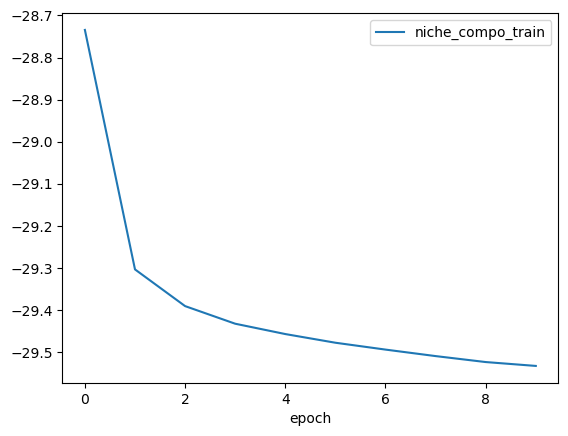

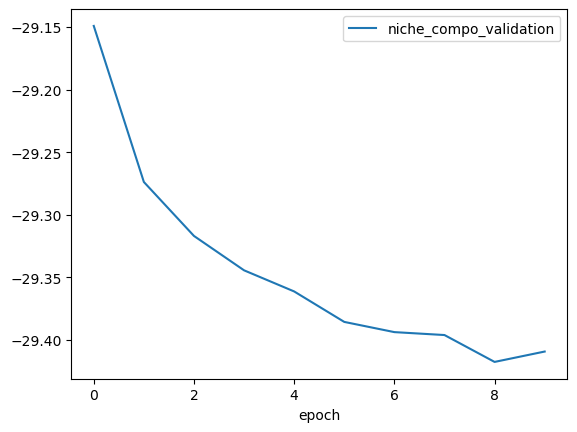

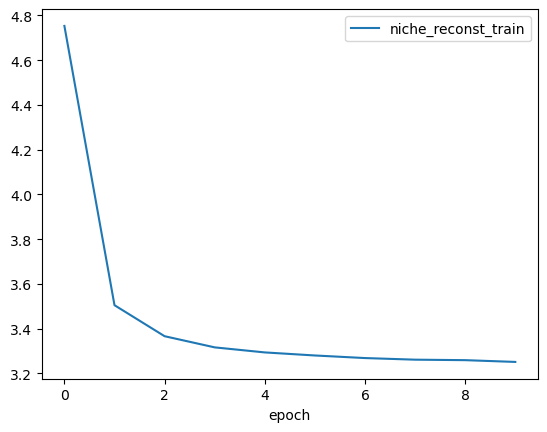

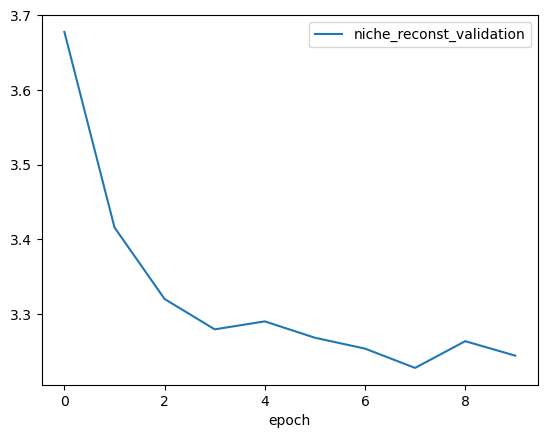

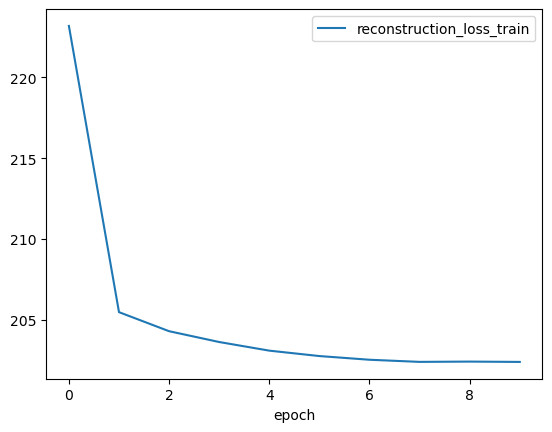

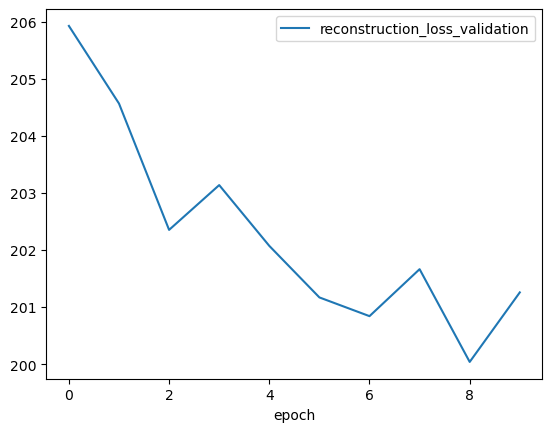

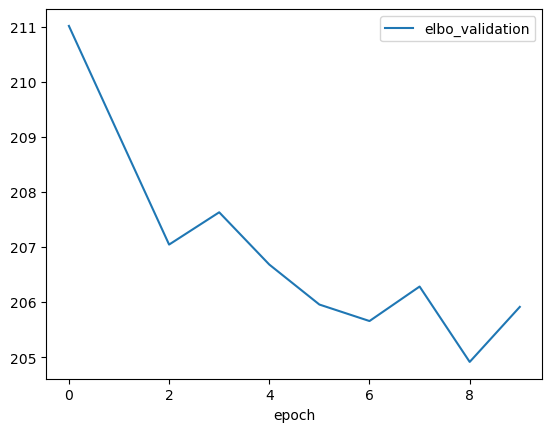

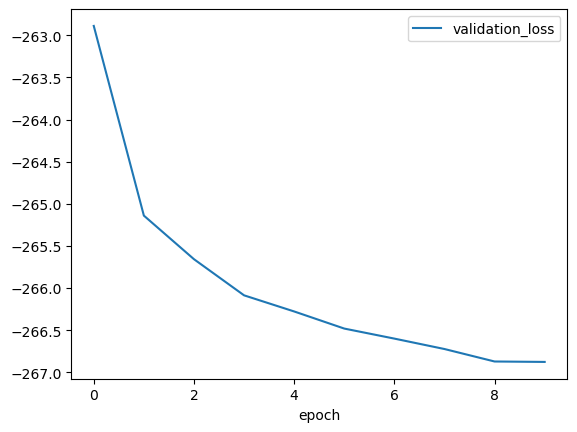

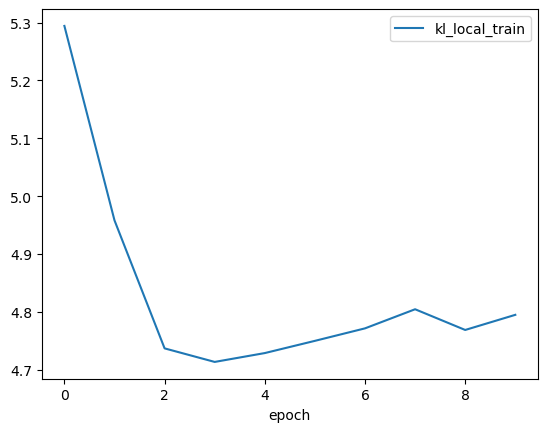

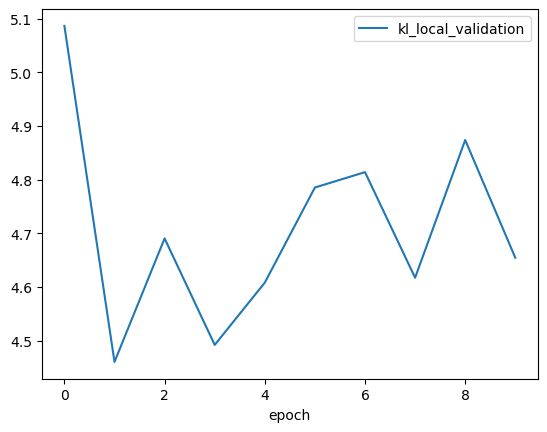

In [ ]:
key = setup
# key = "r01_kl1_c1_n10"

history_setup[key]["niche_compo_train"].plot()
history_setup[key]["niche_compo_validation"].plot()
history_setup[key]["niche_reconst_train"].plot()
history_setup[key]["niche_reconst_validation"].plot()
history_setup[key]["reconstruction_loss_train"].plot()
history_setup[key]["reconstruction_loss_validation"].plot()
history_setup[key]["elbo_validation"].plot()
history_setup[key]["validation_loss"].plot()
history_setup[key]["kl_local_train"].plot()
history_setup[key]["kl_local_validation"].plot()

In [ ]:
# key = setup
# key = "L_r0_kl50_c50_t1"

# history_setup[key]["niche_CE_train"].plot()
# history_setup[key]["niche_CE_validation"].plot()
# history_setup[key]["niche_kl_train"].plot()
# history_setup[key]["niche_kl_validation"].plot()
# history_setup[key]["reconstruction_loss_train"].plot()
# history_setup[key]["reconstruction_loss_validation"].plot()
# history_setup[key]["elbo_validation"].plot()
# history_setup[key]["validation_loss"].plot()
# history_setup[key]["kl_local_validation"].plot()

In [ ]:
# key = "mix_unif_kl10_compo10"

# history_setup[key]["reconstruction_loss_train"].plot()
# history_setup[key]["niche_kl_train"].plot()
# history_setup[key]["niche_CE_train"].plot()
# history_setup[key]["elbo_validation"].plot()

In [ ]:
# history_setup['cell_type_setup_mixture']['kl_local_train'].plot()

In [ ]:
if plots:
    sc.pp.neighbors(adata, use_rep=setup + "_X_nicheVI")
    sc.tl.umap(adata, min_dist=0.3)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


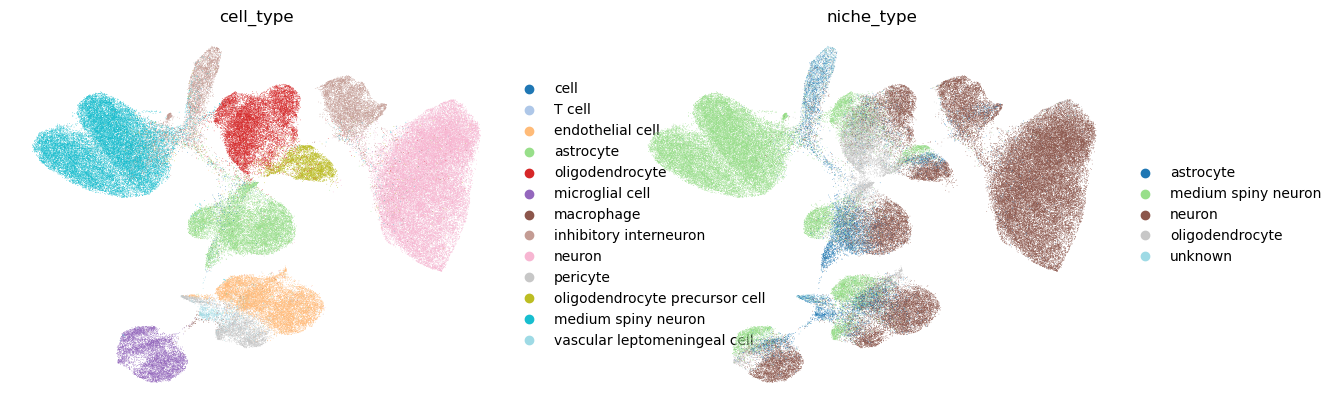

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type", "niche_type"],
    ncols=3,
    frameon=False,
    palette="tab20",
)

## scib-metrics

In [ ]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]
# adata.obsm["X_scVI"] = scvivae.get_latent_representation()

print(adata.obsm)

AxisArrays with keys: X_pca, X_spatial, X_umap, spatial, centroids, X_scVI, qz1_m, qz1_var, niche_indexes, 
niche_distances, neighborhood_composition, latent_mean_knn, qz1_m_niche_ct, qz1_var_niche_ct, 
r01_kl01_c1_n1_X_nicheVI, r01_kl01_c1_n1_pred_ct, r0_kl01_c0_n10_X_nicheVI, r0_kl01_c0_n10_pred_ct, 
r0_kl01_c10_n0_X_nicheVI, r0_kl01_c10_n0_pred_ct, r01_kl01_c10_n10_X_nicheVI, r01_kl01_c10_n10_pred_ct, 
r01_kl1_c10_n10_X_nicheVI, r01_kl1_c10_n10_pred_ct, r01_kl1_c1_n10_X_nicheVI, r01_kl1_c1_n10_pred_ct, X_ldvae

Computing neighbors:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings:  29%|██▊       | 2/7 [05:33<13:50, 166.03s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  57%|█████▋    | 4/7 [10:55<08:08, 162.80s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 7/7 [19:08<00:00, 164.10s/it]


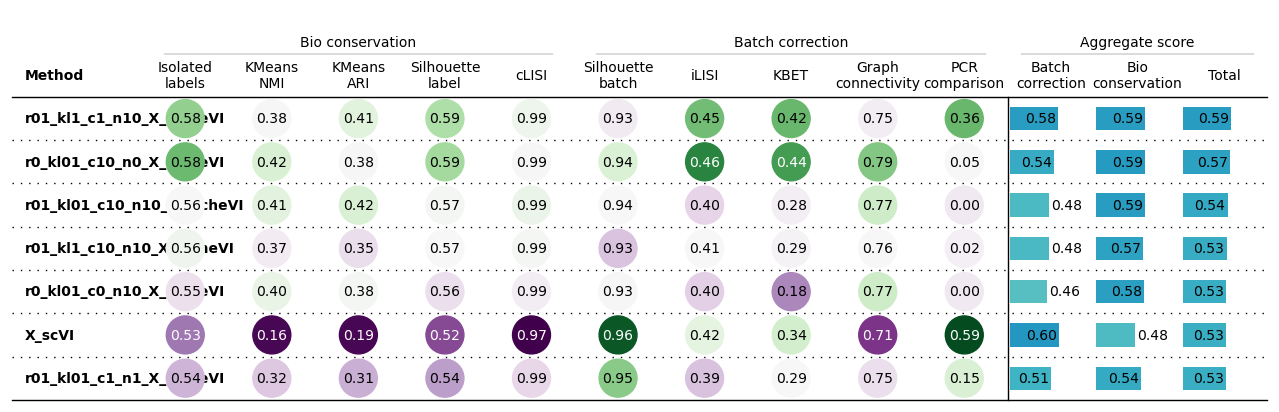

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="niche_type",
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

Computing neighbors:  86%|████████▌ | 6/7 [06:14<01:02, 62.23s/it]

Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


Embeddings:  14%|█▍        | 1/7 [02:00<12:04, 120.80s/it]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


Embeddings:  29%|██▊       | 2/7 [03:23<08:13, 98.61s/it] 

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  43%|████▎     | 3/7 [04:40<05:53, 88.45s/it]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


Embeddings:  57%|█████▋    | 4/7 [05:56<04:10, 83.46s/it]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  71%|███████▏  | 5/7 [07:15<02:44, 82.19s/it]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


Embeddings:  86%|████████▌ | 6/7 [08:36<01:21, 81.75s/it]

INFO     medium spiny neuron_T cell consists of a single batch or is too small. Skip.                              
INFO     unknown_cell consists of a single batch or is too small. Skip.                                            


Embeddings: 100%|██████████| 7/7 [09:55<00:00, 85.08s/it]


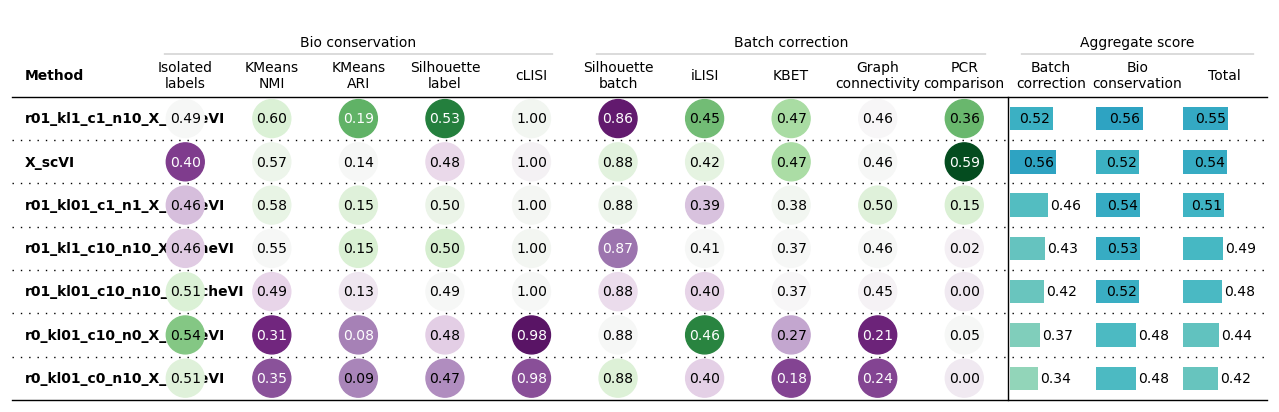

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="niche_cell_type",
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

Computing neighbors:  71%|███████▏  | 5/7 [05:14<02:05, 62.57s/it]

Embeddings:  29%|██▊       | 2/7 [11:27<28:34, 342.81s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  57%|█████▋    | 4/7 [23:01<17:17, 345.76s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 7/7 [40:10<00:00, 344.32s/it]


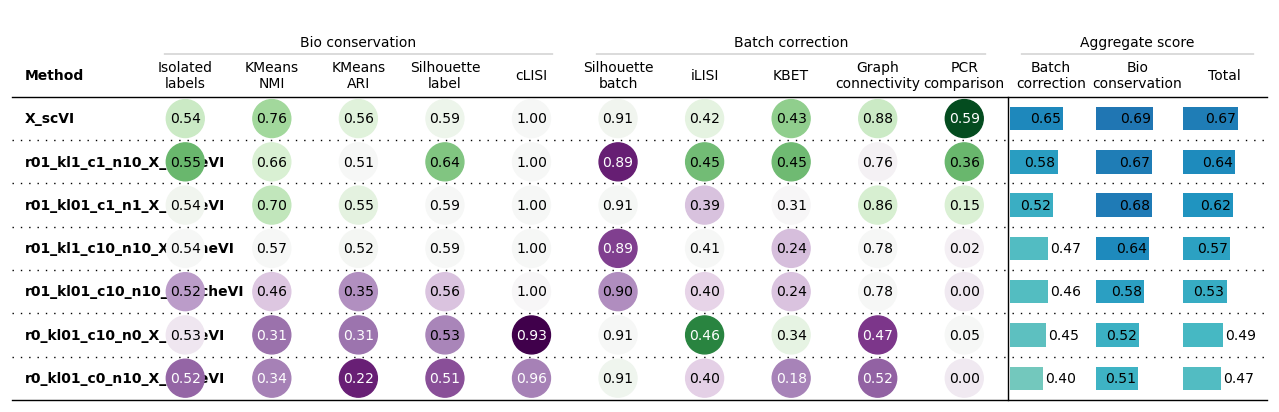

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [ ]:
# df = bm.get_results(min_max_scale=False)
# print(df)

## spatial metrics

In [ ]:
sa = SpatialAnalysis(
    adata=adata,
    label_key="cell_type",
    sample_key="donor_slice",
    latent_space_keys=[
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
    z1_reference="X_scVI",
    z2_comparison="whatever",
)

In [ ]:
# sa.leiden_clusters(
#     resolution=0.5,
#     sample_subset=["Donor_8-slice_0", "Donor_1-slice_0", "Donor_7-slice_0"],
#     plot=False,
# )

In [ ]:
sa.compute_metrics(
    k_nn=50,  # what is the optimal k_nn?
    set_of_metrics=["distance", "similarity"],
    similarity_metric="kl",
    reduction=["mean", "mean"],
)

X_scVI:   0%|          | 0/10 [00:00<?, ?it/s]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the c

r01_kl01_c10_n10_X_nicheVI:  80%|████████  | 8/10 [00:53<00:13,  6.64s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
r01_kl1_c1_n10_X_nicheVI:  10%|█         | 1/10 [00:07<01:07,  7.54s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
r01_kl1_c1_n10_X_nicheVI: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


In [ ]:
# sa.cluster_stats["X_scVI"].mean

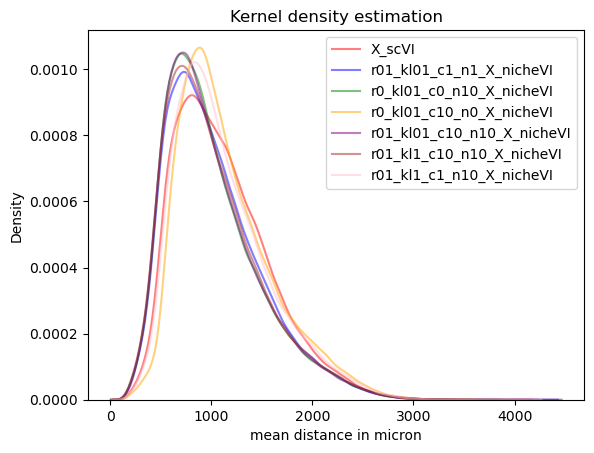

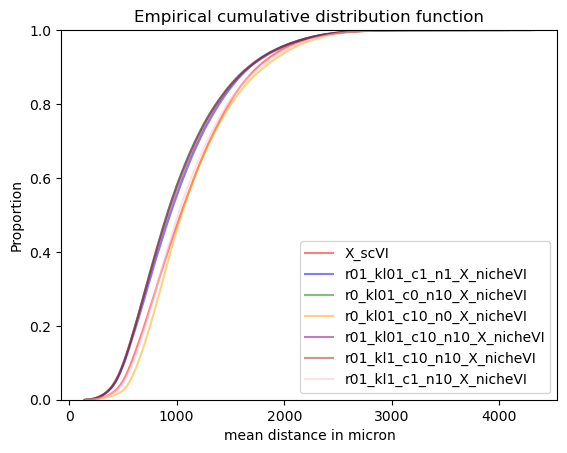

In [ ]:
sa.plot_metrics(metric="distance", plot_type="kde")
sa.plot_metrics(metric="distance", plot_type="ecdf")

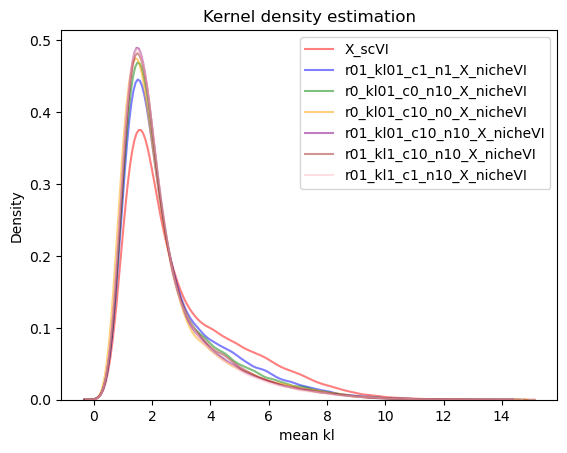

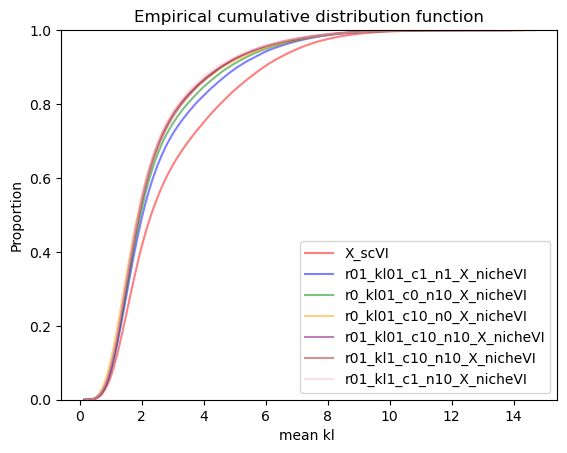

In [ ]:
sa.plot_metrics(metric="similarity", plot_type="kde")
sa.plot_metrics(metric="similarity", plot_type="ecdf")

In [ ]:
df_dist = sa.test_distributions(
    test="mannwhitneyu",
    distribution="distance",
    train_indices=nichevae.train_indices,
    validation_indices=nichevae.validation_indices,
)
df_dist

,Mean distance train,Var distance train,p-value corrected train,Mean distance validation,Var distance validation,p-value corrected validation
Model,,,,,,
r01_kl01_c10_n10_X_nicheVI,1001.116,213864.653,0.0,1044.422,235931.747,0.0
r01_kl01_c1_n1_X_nicheVI,1024.310,217956.512,0.0,1046.471,226440.737,0.0
r0_kl01_c0_n10_X_nicheVI,998.960,214288.488,0.0,1046.555,233562.302,0.0
r01_kl1_c10_n10_X_nicheVI,1008.540,218984.013,0.0,1052.304,239736.101,0.0
X_scVI,1110.300,218437.467,1.0,1108.799,216104.083,1.0
r01_kl1_c1_n10_X_nicheVI,1101.256,217279.172,0.0,1136.287,233647.689,0.0
r0_kl01_c10_n0_X_nicheVI,1137.059,214056.913,0.0,1174.190,225978.461,0.0


In [ ]:
df_sim = sa.test_distributions(
    test="mannwhitneyu",
    distribution="similarity",
    train_indices=nichevae.train_indices,
    validation_indices=nichevae.validation_indices,
)
df_sim

,Mean similarity train,Var similarity train,p-value corrected train,Mean similarity validation,Var similarity validation,p-value corrected validation
Model,,,,,,
r01_kl01_c10_n10_X_nicheVI,2.346,2.227,0.0,2.617,3.497,0.0
r01_kl1_c1_n10_X_nicheVI,2.307,2.119,0.0,2.635,3.628,0.0
r01_kl1_c10_n10_X_nicheVI,2.364,2.205,0.0,2.641,3.510,0.0
r0_kl01_c10_n0_X_nicheVI,2.313,2.346,0.0,2.676,3.714,0.0
r0_kl01_c0_n10_X_nicheVI,2.455,2.489,0.0,2.678,3.544,0.0
r01_kl01_c1_n1_X_nicheVI,2.580,2.794,0.0,2.718,3.440,0.0
X_scVI,2.989,3.822,1.0,2.992,3.869,1.0


In [ ]:
# sa.get_latent_overlap()

In [ ]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    validation_indices=nichevae.validation_indices,
    validation_only=True,
)
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    train_indices=nichevae.train_indices,
    train_only=True,
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Saved metric in: 
[
    'val_corr_r01_kl01_c1_n1_pred_ct',
    'val_corr_r0_kl01_c0_n10_pred_ct',
    'val_corr_r0_kl01_c10_n0_pred_ct',
    'val_corr_r01_kl01_c10_n10_pred_ct',
    'val_corr_r01_kl1_c10_n10_pred_ct',
    'val_corr_r01_kl1_c1_n10_pred_ct'
]

Saved metric in: 
[
    'train_corr_r01_kl01_c1_n1_pred_ct',
    'train_corr_r0_kl01_c0_n10_pred_ct',
    'train_corr_r0_kl01_c10_n0_pred_ct',
    'train_corr_r01_kl01_c10_n10_pred_ct',
    'train_corr_r01_kl1_c10_n10_pred_ct',
    'train_corr_r01_kl1_c1_n10_pred_ct'
]

In [134]:
adata.uns["val_corr_r01_kl1_c1_n10_pred_ct"]

,astrocyte,inhibitory interneuron,microglial cell,oligodendrocyte,neuron,endothelial cell,medium spiny neuron,oligodendrocyte precursor cell,pericyte,macrophage,vascular leptomeningeal cell,T cell,cell,weighted_mean
astrocyte,0.538965,0.340144,0.071637,0.672021,0.654133,0.206270,0.627210,0.079185,0.212469,0.053058,0.622025,0.036947,0.126004,0.505141
inhibitory interneuron,0.368159,0.722595,-0.007358,0.297729,0.733782,0.117240,0.776140,0.038342,0.038215,0.101214,0.081792,0.007901,0.089055,0.508522
microglial cell,0.339326,0.230720,0.035400,0.500632,0.694597,0.134635,0.642214,0.121957,0.074347,0.080637,0.238571,0.037504,0.077349,0.456743
oligodendrocyte,0.205105,0.247171,0.094031,0.520413,0.591153,0.123399,0.456391,0.108001,0.026637,0.026833,0.017899,-0.024746,-0.012752,0.377311
neuron,0.167076,0.248649,0.084113,0.478492,0.283572,0.161178,0.585403,0.040481,0.035546,0.061045,0.132049,0.056141,0.057683,0.311695
endothelial cell,0.250749,0.138387,-0.020042,0.377334,0.555167,0.096890,0.493924,0.000244,0.363571,0.054220,0.356467,0.026810,0.059878,0.355736
medium spiny neuron,0.190472,0.480203,0.065123,0.212159,0.557191,0.027825,0.384279,0.074211,0.029302,0.056367,0.051187,-0.005770,0.031959,0.327059
oligodendrocyte precursor cell,0.279867,0.333540,0.018507,0.691565,0.649305,0.206208,0.564949,0.159659,0.097586,0.034877,0.146454,0.015348,0.017425,0.458138
pericyte,0.269352,0.148248,0.087436,0.552928,0.561531,0.148805,0.530278,0.086845,0.691170,0.092023,0.589749,0.029891,-0.023809,0.411225
macrophage,0.581445,0.643647,-0.071013,0.692350,0.774569,0.319776,0.642967,-0.055309,0.532948,0.172620,0.552080,0.219066,0.081039,0.581338


In [135]:
adata.uns["train_corr_r01_kl1_c1_n10_pred_ct"]

,astrocyte,inhibitory interneuron,microglial cell,oligodendrocyte,neuron,endothelial cell,medium spiny neuron,oligodendrocyte precursor cell,pericyte,macrophage,vascular leptomeningeal cell,T cell,cell,weighted_mean
astrocyte,0.608964,0.474976,0.124924,0.751589,0.768240,0.271004,0.807027,0.147021,0.301606,0.113243,0.618831,0.037325,0.153291,0.615913
inhibitory interneuron,0.488968,0.789136,0.067874,0.484345,0.854419,0.210918,0.907336,0.116617,0.081295,0.076008,0.206245,0.023427,0.156003,0.626750
microglial cell,0.469189,0.363172,0.082771,0.621655,0.773044,0.188190,0.818631,0.165692,0.128070,0.084426,0.376511,0.049688,0.104482,0.565670
oligodendrocyte,0.275399,0.385814,0.073845,0.706080,0.701800,0.200908,0.649465,0.142913,0.061257,0.041567,0.053097,0.000176,-0.001816,0.496128
neuron,0.199182,0.329870,0.103936,0.620037,0.390944,0.251850,0.742620,0.046028,0.047963,0.060230,0.096689,0.025311,0.087668,0.410053
endothelial cell,0.411043,0.286231,0.052397,0.552352,0.713561,0.207471,0.755344,0.118762,0.473677,0.106171,0.441822,0.054830,0.085992,0.524964
medium spiny neuron,0.254298,0.561056,0.076642,0.324828,0.759159,0.080798,0.512250,0.084050,0.026267,0.081297,0.055771,0.002263,0.088251,0.442101
oligodendrocyte precursor cell,0.423020,0.469281,0.080255,0.797074,0.783590,0.268017,0.749314,0.206517,0.153841,0.061848,0.281423,0.066005,0.081184,0.585260
pericyte,0.406779,0.309742,0.094899,0.573126,0.716382,0.199226,0.766082,0.143088,0.710383,0.112573,0.630916,0.030548,0.065286,0.542255
macrophage,0.579571,0.571633,-0.022388,0.669273,0.816582,0.229580,0.800873,0.100704,0.400226,0.141988,0.627124,0.166922,0.136616,0.614437


In [ ]:
adata.uns["corr_L_r0_kl0_c100_t1_pred_ct"]

,astrocyte,inhibitory interneuron,microglial cell,oligodendrocyte,neuron,endothelial cell,medium spiny neuron,oligodendrocyte precursor cell,pericyte,macrophage,vascular leptomeningeal cell,T cell,cell,weighted_mean
astrocyte,0.634732,0.599321,0.173271,0.782089,0.780795,0.309148,0.875224,0.225458,0.397566,0.274166,0.672762,0.160155,0.390475,0.662670
inhibitory interneuron,0.499141,0.818385,0.153101,0.470873,0.857159,0.230455,0.923527,0.162870,0.137770,0.129854,0.410200,0.120247,0.359850,0.644711
microglial cell,0.467281,0.498417,0.148957,0.680306,0.799976,0.261891,0.878608,0.225507,0.227399,0.134100,0.602937,0.140275,0.230341,0.620447
oligodendrocyte,0.320574,0.509741,0.143561,0.731209,0.766358,0.263251,0.790357,0.272561,0.133228,0.062425,0.160200,0.018706,0.185552,0.578279
neuron,0.153335,0.266256,0.070526,0.549433,0.306560,0.128035,0.771029,0.052684,0.060246,0.054353,0.153665,0.062237,0.141811,0.362901
endothelial cell,0.441610,0.419513,0.149262,0.626695,0.752435,0.298494,0.840547,0.190055,0.552282,0.195935,0.557372,0.263180,0.434552,0.595724
medium spiny neuron,0.256548,0.562214,0.038035,0.206696,0.757081,0.052959,0.484557,0.083230,0.023245,0.087134,0.216054,0.001955,0.105586,0.420451
oligodendrocyte precursor cell,0.461412,0.563611,0.184654,0.811081,0.794278,0.308689,0.856352,0.323596,0.274097,0.154329,0.489002,0.060333,0.228749,0.642709
pericyte,0.453828,0.450332,0.170898,0.663125,0.783163,0.274421,0.868266,0.236415,0.770526,0.238565,0.705547,0.325126,0.251533,0.625489
macrophage,0.648297,0.663192,0.000417,0.665591,0.863068,0.249657,0.899963,0.215540,0.486281,0.263554,0.703665,0.239842,0.412512,0.673338


In [ ]:
adata.uns["corr_mix_e1_kl1_c1_pred_ct"]

,astrocyte,inhibitory interneuron,microglial cell,oligodendrocyte,neuron,endothelial cell,medium spiny neuron,oligodendrocyte precursor cell,pericyte,macrophage,vascular leptomeningeal cell,T cell,cell,weighted_mean
astrocyte,0.521457,0.336908,0.153506,0.682073,0.672836,0.246488,0.638250,0.145244,0.335256,0.255475,0.606100,0.114626,0.355669,0.527007
inhibitory interneuron,0.387702,0.742907,0.103745,0.300687,0.761065,0.150208,0.699434,0.106702,0.052211,0.102917,0.161008,0.023093,0.287554,0.518657
microglial cell,0.340740,0.295195,0.098480,0.548229,0.699008,0.192847,0.671642,0.141247,0.148534,0.102803,0.451638,0.085473,0.124446,0.489426
oligodendrocyte,0.208686,0.255115,0.113426,0.529353,0.607823,0.191753,0.490167,0.161110,0.061779,0.053435,0.070533,0.015870,0.142143,0.402499
neuron,0.170820,0.254214,0.123720,0.510441,0.298900,0.198002,0.565711,0.067904,0.056914,0.092251,0.079066,0.012670,0.111746,0.323740
endothelial cell,0.269812,0.171703,0.090010,0.478579,0.581260,0.196569,0.562759,0.100269,0.512020,0.145370,0.425202,0.163780,0.230444,0.417586
medium spiny neuron,0.204092,0.472908,0.088110,0.212706,0.658576,0.075061,0.388099,0.069911,0.016342,0.066999,0.072115,0.002948,0.123278,0.363224
oligodendrocyte precursor cell,0.277222,0.349210,0.108132,0.683910,0.674565,0.222390,0.593801,0.225361,0.146384,0.095405,0.251597,0.044683,0.178261,0.483003
pericyte,0.249251,0.207434,0.139196,0.434357,0.585796,0.134255,0.544393,0.123630,0.716752,0.213580,0.609989,0.275002,0.209019,0.416379
macrophage,0.432211,0.521295,0.027010,0.504844,0.777819,0.304328,0.620865,0.104651,0.415830,0.203281,0.590138,0.142939,0.211292,0.539237


## EXPERIMENTAL